# Claim Normalization

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import transformers, datasets, sentencepiece
import torch
!pip install contractions evaluate bert-score rouge-score --quiet

## DataSet Splitting (70 : 15 : 15)

In [7]:
# Load the dataset
df = pd.read_csv('/kaggle/input/nlp-a3/CLAN_data.csv')

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## Preprocessing Dataset

In [8]:
import re
import contractions

# Custom abbreviation dictionary
abbreviation_map = {
    "Gov.": "Governor",
    "VP": "Vice President",
    "ETA": "Estimated Time of Arrival",
    "U.S.": "United States",
    "Dr.": "Doctor",
    "Mr.": "Mister",
    "Mrs.": "Mistress",
}

def expand_abbreviations(text):
    for abbr, full in abbreviation_map.items():
        text = re.sub(rf'\b{re.escape(abbr)}\b', full, text)
    return text

def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove special characters (except basic punctuation)
    text = re.sub(r"[^\w\s.,!?]", "", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess(df):
    df = df.copy()
    def process_post(text):
        if pd.isnull(text):
            return text
        text = contractions.fix(text) # Expand Contraction
        text = expand_abbreviations(text) # Expan Abbreviations
        text = clean_text(text) # Clean Text
        text = text.lower()
        return text
    
    df["Social Media Post"] = df["Social Media Post"].apply(process_post)
    df["Normalized Claim"] = df["Normalized Claim"].apply(process_post)
    df = df[['Social Media Post', 'Normalized Claim']].dropna()
    df.columns = ['input_text', 'target_text']
    return df

train_df =  preprocess(train_df)
val_df =  preprocess(val_df)
test_df =  preprocess(test_df)

# Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Save csv
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

Train size: 1967
Validation size: 422
Test size: 422


In [9]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## T5 Model
#### Tokenization

In [10]:
from transformers import BartTokenizer
# Load tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Tokenization function
def tokenize_function(example):
    model_inputs = tokenizer(
        example["input_text"],
        max_length=512,
        padding="max_length",
        truncation=True,
    )
    labels = tokenizer(
        example["target_text"],
        max_length=128,
        padding="max_length",
        truncation=True,
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply tokenization
train_tokenized = train_dataset.map(tokenize_function, batched=False)
val_tokenized = val_dataset.map(tokenize_function, batched=False)
test_tokenized = test_dataset.map(tokenize_function, batched=False)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Map:   0%|          | 0/1967 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

#### Training

In [11]:
from transformers import BartForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

training_args = TrainingArguments(
    output_dir="./bart-normalizer",
    evaluation_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to = "none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()
trainer.save_model("bart-claim-normalizer")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-f2e01fd1bb49>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
50,6.592400,1.958104
100,1.144200,0.538470
150,0.556500,0.520429
200,0.508200,0.466945
250,0.521300,0.460375
300,0.395900,0.460981
350,0.416400,0.453082
400,0.393100,0.452555
450,0.428900,0.443097
500,0.424900,0.436796


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'train_runtime': 378.2484, 'train_samples_per_second': 15.601, 'train_steps_per_second': 1.951, 'total_flos': 1799027420037120.0, 'train_loss': 0.8812487894280493, 'epoch': 3.0, 'step': 738}


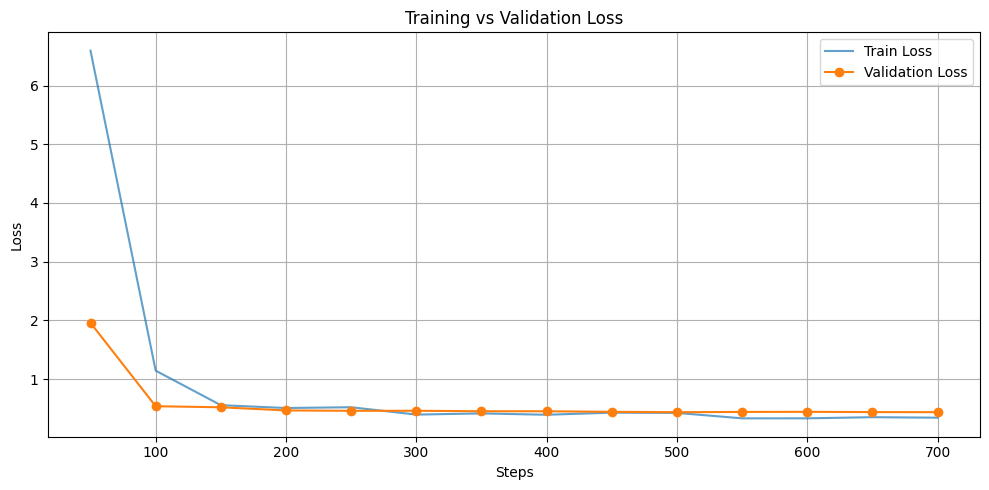

In [12]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
print(log_history[-1])

# Training and eval loss
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for log in log_history:
    if "loss" in log:
        train_steps.append(log["step"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_loss.append(log["eval_loss"])

# Plotting
plt.figure(figsize=(10, 5))
if train_steps:
    plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.7)
if eval_steps:
    plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Evaluation (ROUGE-L, BLEU-4, BERTScore)

In [13]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import bert_score
from tqdm import tqdm

def evaluate(test_tokenized, model, tokenizer, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    references = []

    for i in tqdm(range(0, len(test_tokenized), 8), desc="Evaluating"):
        batch = test_tokenized[i:i+8]
    
        input_ids = torch.tensor(batch['input_ids']).to(device)
        attention_mask = torch.tensor(batch['attention_mask']).to(device)
        target_texts = batch['target_text']  
        with torch.no_grad():
            output_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=128,
                num_beams=2,
                early_stopping=True
            )

        batch_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        # for pred, ref in zip(batch_preds, target_texts):
        #     if pred.strip():  # Only keep non-empty predictions
        #         predictions.append(pred)
        #         references.append(ref)
        predictions.extend(batch_preds)
        references.extend(target_texts)
    
    # ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_scores = [scorer.score(ref, pred)['rougeL'].fmeasure for ref, pred in zip(references, predictions)]
    avg_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)

    # BLEU-4
    smoothing = SmoothingFunction().method4
    bleu_scores = []
    for ref, pred in zip(references, predictions):
        pred_tokens = pred.strip().split()
        ref_tokens = ref.strip().split()
        if len(pred_tokens) < 2 or len(ref_tokens) < 2:
            continue  # Skip empty predictions or references
        score = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        bleu_scores.append(score)
    
    avg_bleu4 = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0

    # BERTScore
    P, R, F1 = bert_score.score(predictions, references, lang="en", verbose=False)
    avg_bertscore_f1 = F1.mean().item()
    
    return {
        "ROUGE-L": round(avg_rouge_l, 4),
        "BLEU-4": round(avg_bleu4, 4),
        "BERTScore (F1)": round(avg_bertscore_f1, 4)
    }

In [14]:
evaluate(test_tokenized, model, tokenizer, batch_size=8)

Evaluating: 100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'ROUGE-L': 0.348, 'BLEU-4': 0.2552, 'BERTScore (F1)': 0.8835}

In [15]:
import shutil

# Path where model is saved (from `trainer.save_model`)
model_dir = "bart-claim-normalizer"

# Output zip file name (it will create t5-claim-normalizer.zip)
zip_name = "bart-claim-normalizer"

# Create the zip file
shutil.make_archive(zip_name, 'zip', model_dir)

'/kaggle/working/bart-claim-normalizer.zip'